<a href="https://colab.research.google.com/github/jej0312/DM_TA/blob/main/6_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression (로지스틱 회귀)
- TA: 전은지 (Eunji Jeon)  
- Dept. of Industrial Engineering, Yonsei Univ (Industrial Statistics Lab; ISL 산업통계연구실)
- 문의: `jej_0312_@naver.com`

- 로지스틱 회귀는 다음과 같은 상황에서 사용할 수 있음
  1. binary target을 모델링하는 경우
  2. 예측 확률을 알고 싶은 경우
  3. **해석 가능한 모델**을 얻고자 하는 경우
  4. 클래스를 선형으로 분리 가능한 경우

## Assumptions
1. 관측치들 간 독립성: 데이터의 샘플들은 랜덤하게 얻어져야 함. (반복적 측정 X, 시간 및 공간에 따른 상관관계 X)
  - 본 실습에서 활용하는 타이타닉 데이터의 경우 개별 승객 기록으로 구성되므로 자동 충족
2. 잔차 간 등분산성
3. 독립 변수와 log odds 간의 linearity (R에서는 car package에 [Box-Tidwell](https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290) 수행하는 라이브러리 제공)
4. 이상치가 존재하지 않아야 함
- 추가적으로, 적당한 수의 샘플이 존재해야 함.
- 또한, independent variables가 너무 많을 경우 일반화 성능이 감소할 수 있음.
- 확인하는 방법에 대한 자세한 설명 [참고](https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290)

- 다중 로지스틱 회귀모형의 일반적 형태
  - $\log(\frac{π(x)}{1-π(x)})=α+β_1x_1+\cdots+\beta_kx_k$
  - where $π(x)=P(Y=1|x), x=(x_1, \cdots, x_k)$
  - $π(x)$는 다음과 같이 재표현할 수 있음
    - $π(x)=\frac{exp(α+β_1x_1+\cdots+\beta_kx_k)}{1+exp(\alpha+\beta_1x_1+\cdots+\beta_kx_k)}=\frac{1}{1+exp\{-(\alpha+\beta_1x_1+\cdots+\beta_kx_k)\}}$
    - 따라서 sigmoid ($s(z)=\frac{1}{1+e^{-z}}$)와 동일한 형태 (더 자세한 설명 [참고](https://icim.nims.re.kr/post/easyMath/64))


> ## Sigmoid (Logit) Function
- predicted response variable은 0과 1 사이의 확률 값
  - 이 때 sigmoid function을 사용하면 실수 값을 0과 1 사이의 확률 값으로 표현됨

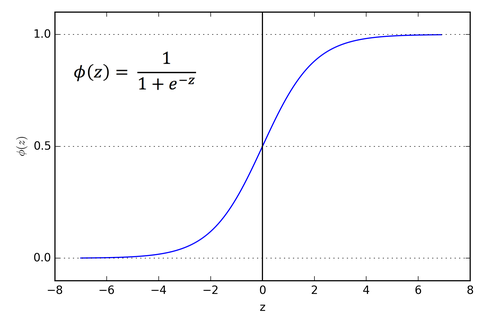

- sigmoid function을 통해 0과 1의 함수로 나타내기 위해 Decision Boundary (threshold)를 설정해줌
  - 해당 threshold를 넘을 경우 class 1, 그렇지 않은 경우 class 0으로 분류
- 예를 들어, threshold를 0.5로 설정하는 경우
  - if p ≥ 0.5, then class = 1
  - if p < 0.5, then class = 0

# Step 1. Data Preprocessing

- dataset: [titanic dataset](https://www.kaggle.com/c/titanic/data) from kaggle

In [ ]:
import pandas as pd
passengers = pd.read_csv("https://raw.githubusercontent.com/jej0312/DM_TA/main/data/titanic_passengers.csv")

In [ ]:
passengers.shape # (행, 열)

(891, 12)

In [ ]:
passengers.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
passengers.isnull().sum() # 결측치: (Age 177명, Cabin 687명, Embarked 2명)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- 불필요한 컬럼 제거
  - 'Cabin': 891명 중 687명(77.1%)이 결측치이므로, 해당 열 제거
  - 'Ticket', 'Passengerid': 큰 의미가 없으므로, 해당 열 제거
  - 본 실습에서는 편의상 'SibSp' (동반한 형제자매, 배우자수)와 'Parch'(동반한 부모, 자식 수)도 제거


In [ ]:
passengers.drop(['Cabin', 'Ticket', 'PassengerId'], axis = 1, inplace = True)

In [ ]:
passengers.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

In [ ]:
passengers.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,S


- 파생변수 생성
  - Name에서 Title 추출

In [ ]:
# Name에서 Title만 떼어내기
for passenger in [passengers.copy()]:
    passenger['Title'] = passenger['Name'].str.extract('([A-za-z]+)\.', expand=False) # 알파벳 + '.'으로 된 부분 추출

In [ ]:
passenger["Title"].value_counts() # Mr, Miss, Mrs, others로 구분하는게 편리할 것으로 보임

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [ ]:
title_mapping = {k: 'others' for k in set(passenger['Title'].unique()) - set(['Mr', 'Mrs', 'Miss'])}
print(title_mapping)

{'Countess': 'others', 'Don': 'others', 'Col': 'others', 'Ms': 'others', 'Rev': 'others', 'Lady': 'others', 'Jonkheer': 'others', 'Dr': 'others', 'Capt': 'others', 'Sir': 'others', 'Master': 'others', 'Major': 'others', 'Mme': 'others', 'Mlle': 'others'}


In [ ]:
for passenger in [passenger.copy()]:
    passenger['Title'] = passenger['Title'].apply(lambda x: title_mapping[x] if x not in ['Mr', 'Mrs', 'Miss'] else x)

In [ ]:
passenger["Title"].value_counts() # Mr, Miss, Mrs, others로 구분하는게 편리할 것으로 보임

Mr        517
Miss      182
Mrs       125
others     67
Name: Title, dtype: int64

In [ ]:
# 불필요한 Name 열 제거
passenger.drop(['Name'], axis = 1, inplace = True)

In [ ]:
passenger.isnull().sum() # 결측치 확인: (Age 177명, Embarked 2명)

Survived      0
Pclass        0
Sex           0
Age         177
Fare          0
Embarked      2
Title         0
dtype: int64

- 결측치 처리 : Age(177명)와 Embarked(2명)

In [ ]:
# 'Embarked'에서 NA가 2개뿐 & 대부분(72.4%)이 'S'이므로, 결측치들도 S로 "대체"
passenger = passenger.fillna({"Embarked": "S"})

In [ ]:
# 'Age'를 각 'Title'에 대한 Age값의 중간값(median) 으로 채운다
passenger['Age'].fillna(passenger.groupby('Title')['Age'].transform('median'), inplace=True)

In [ ]:
passenger.isnull().sum() # 결측치 확인: (Age 177명, Embarked 2명)

Survived    0
Pclass      0
Sex         0
Age         0
Fare        0
Embarked    0
Title       0
dtype: int64

# Step 2. EDA

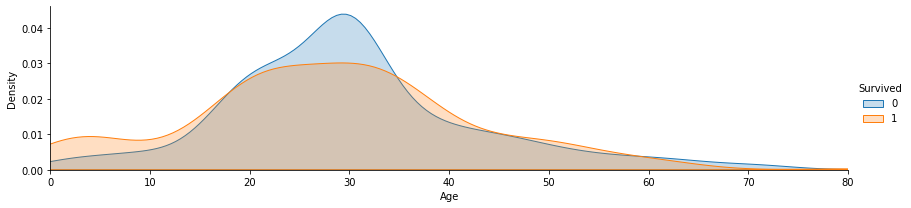

In [ ]:
# Age(나이)에 따른 survived (0: 사망, 1: 생존)비교

import matplotlib.pyplot as plt
import seaborn as sns

facet = sns.FacetGrid(passenger, hue="Survived", aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, passenger['Age'].max()))
facet.add_legend()
sns.axes_style("darkgrid")

plt.show()

# 생존 유무를 통해 Age를 (~10대, 10대, 20대, 30대, 40~50대, 60대 이상)으로 6가지 category로 구분해보자 

- Age 변수 범주화
  - ~10대, 10대, 20대, 30대, 4-50대, 60대 이상으로 구분

In [ ]:
passenger.loc[passenger['Age'] < 10, 'Age'] = 0
passenger.loc[(passenger['Age'] >= 10) & (passenger['Age'] < 20), 'Age'] = 1 # 10대
passenger.loc[(passenger['Age'] >= 20) & (passenger['Age'] < 30), 'Age'] = 2 # 20대
passenger.loc[(passenger['Age'] >= 30) & (passenger['Age'] < 40), 'Age'] = 3 # 30대
passenger.loc[(passenger['Age'] >= 40) & (passenger['Age'] < 60), 'Age'] = 4 # 40-50대
passenger.loc[(passenger['Age'] >= 60), 'Age'] = 5 # 60대 이상
passenger['Age'] = passenger['Age'].apply(int)

In [ ]:
passenger["Age"].value_counts()

3    303
2    256
4    137
1    102
0     67
5     26
Name: Age, dtype: int64

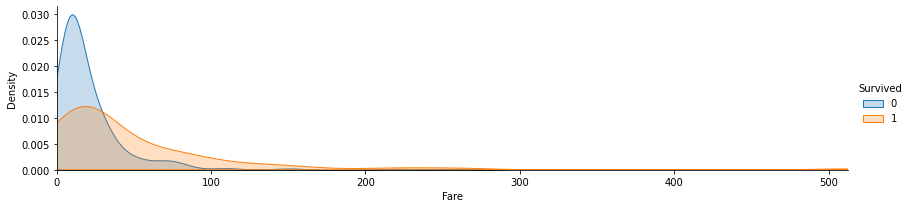

In [ ]:
# Fare에 따른 survived 차이
facet2 = sns.FacetGrid(passenger, hue="Survived", aspect=4)
facet2.map(sns.kdeplot, 'Fare', shade=True)
facet2.set(xlim=(0, passenger['Fare'].max()))
facet2.add_legend()

plt.show() # 운임요금이 낮으면 사망률이 높다.

In [ ]:
passenger['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

- Fare이 일정 수준 이상인 경우 같은 값으로 통일

In [ ]:
passenger.loc[passenger['Fare'] >= 150, 'Fare'] = 150

In [ ]:
# 특정 feature에 따른 survived 비교 (0: 사망, 1: 생존) 함수
def bar_chart(feature):
    survived = passenger[passenger['Survived']==1][feature].value_counts()
    dead = passenger[passenger['Survived']==0][feature].value_counts()
    df_survived = pd.DataFrame([survived,dead])
    df_survived.index = ['Survived','Dead']
    df_survived.plot(kind='bar',stacked=True, figsize=(10,5))

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

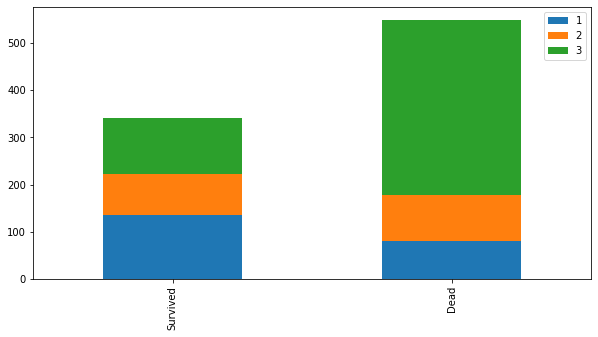

In [ ]:
# Pclass에 따른 survived 차이
bar_chart('Pclass') # 1등석일수록 생존하고, 3등석일수록 사망 (1: 1등석, 2: 2등석, 3: 3등석)
passenger.groupby(['Pclass'])['Survived'].agg(lambda x: x.sum()/x.count()) # survived 확률

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

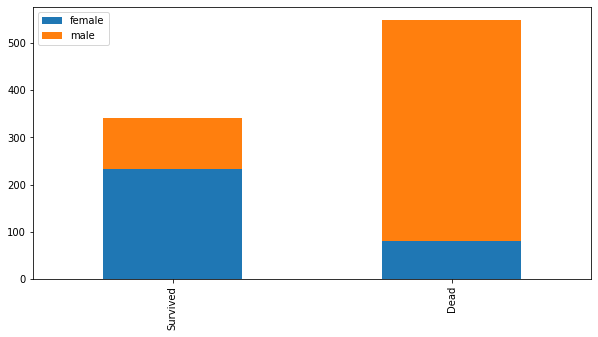

In [ ]:
# Sex에 따른 survived 차이
bar_chart('Sex') # 여성의 생존률이 높다.
passenger.groupby(['Sex'])['Survived'].agg(lambda x: x.sum()/x.count()) # survived 확률

Title
Miss      0.697802
Mr        0.156673
Mrs       0.792000
others    0.522388
Name: Survived, dtype: float64

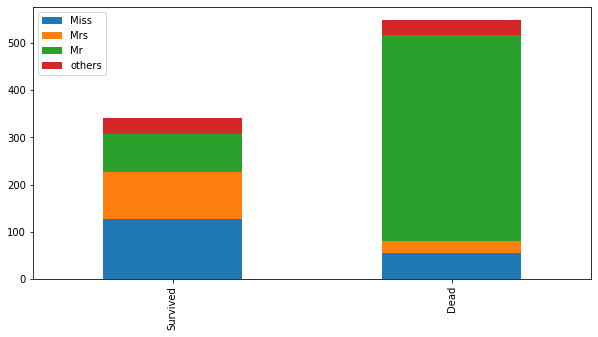

In [ ]:
# Title에 따른 survived 차이
bar_chart('Title') # 남성(Mr)의 사망률이 높다.
passenger.groupby(['Title'])['Survived'].agg(lambda x: x.sum()/x.count()) # survived 확률

Age
0    0.597015
1    0.401961
2    0.386719
3    0.333333
4    0.394161
5    0.269231
Name: Survived, dtype: float64

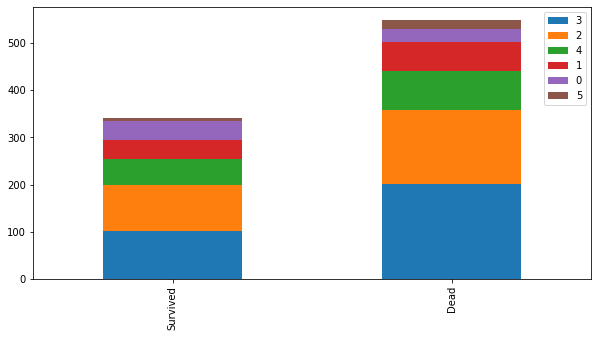

In [ ]:
# Age에 따른 survived 차이
bar_chart('Age') # 60대 이상이 확실히 사망률이 높다.
passenger.groupby(['Age'])['Survived'].agg(lambda x: x.sum()/x.count()) # survived 확률

Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64

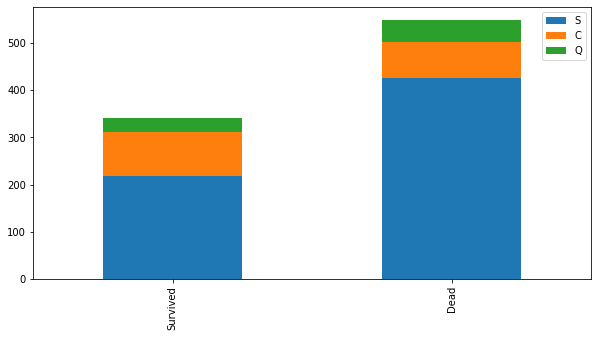

In [ ]:
# Embarked에 따른 survived 차이
bar_chart('Embarked') # C : Cherbourg, Q : Queenstown, S : Southampton; C일 때 생존 확률이 가장 높음
passenger.groupby(['Embarked'])['Survived'].agg(lambda x: x.sum()/x.count()) # survived 확률

In [ ]:
# 유의미하다고 생각되는 column 선택. 실습에서는 임의로 4개 선택 (x = 승선권클래스 Pclass, 성별 Sex, 운임요금 Fare, y = 생존여부 Survived)
passenger = passenger[['Pclass', 'Sex', 'Fare', 'Survived']]

In [ ]:
passenger = pd.get_dummies(passenger, columns = ['Sex', 'Pclass'], drop_first=False) # 두 변수 간 correaltion =1이 되는 것을 방지

In [ ]:
passenger.columns

Index(['Fare', 'Survived', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
       'Pclass_3'],
      dtype='object')

- 다중공선성 확인
  - 5를 초과하는 값이 없으므로 문제 없음

In [ ]:
# Use variance inflation factor to identify any significant multi-collinearity
def calc_vif(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)

calc_vif(passenger)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,variables,VIF
0,Fare,1.861677
1,Survived,1.932878
2,Sex_male,2.651798
3,Pclass_2,1.479735
4,Pclass_3,2.235163


# Step 3. Logistic Regression 
- 설명이 용이함
  - 오즈(odds; $\frac{p}{1-p}$)의 관점에서 해석될 수 있음 (실패에 비해 성공할 확률의 비)
  - $exp(\beta_1)$: 나머지 변수$(x_2,\cdots,x_k)$가 주어질 때 $x_1$이 한 단위 증가할 때마다 성공(Y)의 오즈가 몇 배 증가하는지를 나타내는 값
- 좋은 성능을 기대하기 어려울 수도 있음
- `statsmodel`, `sklearn`
  - `statsmodel`: p-value 등 모델에 대한 summary 정보 제공

In [ ]:
train_features = passenger[['Pclass_2', 'Pclass_3', 'Sex_male', 'Fare']]
train_target = passenger['Survived']
train_target = train_target.astype('int')

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_features, train_target, test_size = 0.2, random_state = 312)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = 312, stratify=y_train)
print("train set:",x_train.shape)
print("valid set:",x_valid.shape)
print("test set:",x_test.shape)

train set: (569, 4)
valid set: (143, 4)
test set: (179, 4)


In [ ]:
y_train.value_counts() # 0: 사망, 1: 생존

0    361
1    208
Name: Survived, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
x_train, y_train = RandomUnderSampler(random_state=312, sampling_strategy='majority').fit_resample(x_train, y_train)

In [ ]:
y_train.value_counts() # 0: 사망, 1: 생존

0    208
1    208
Name: Survived, dtype: int64

In [ ]:
import statsmodels.api as sm
x_train = sm.add_constant(x_train)
x_valid = sm.add_constant(x_valid)
x_test = sm.add_constant(x_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model_sm = sm.Logit(y_train, x_train).fit()
# model_sm = smf.logit("y 변수명 ~ X변수1 + X변수2", data=데이터프레임).fit()의 형태로도 fit 가능

Optimization terminated successfully.
         Current function value: 0.484719
         Iterations 6


# Step 4. Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Probability 값
predict_prob = model_sm.predict(x_valid)

In [ ]:
y_valid.shape

(143,)

- 예측값(fitted)과 잔차(residual)를 비교
- 빨간 실선은 잔차의 추세를 나타냄
- 모든 예측값에서 가운데 점선에 맞추어 잔차가 비슷하게 있어야 하며, 빨간 실선이 점선에서 크게 벗어난다면 예측값에 따라 잔차가 크게 달라짐 = 선형성이 없음

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


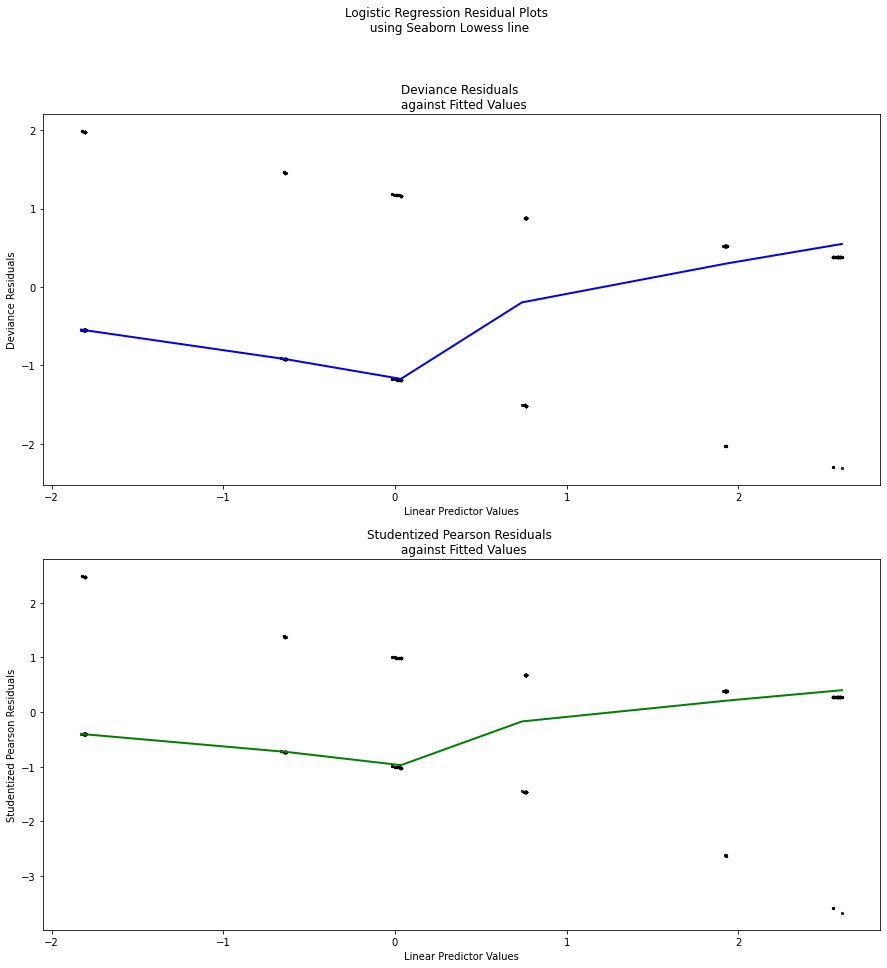

In [ ]:
'''
코드 참고: https://www.pythonfordatascience.org/logistic-regression-python/#assumption_check
해석 참고: https://stats.stackexchange.com/questions/1432/what-do-the-residuals-in-a-logistic-regression-mean; https://stats.oarc.ucla.edu/stata/webbooks/logistic/chapter3/lesson-3-logistic-regression-diagnostics-2/
'''

## Plotting multiple plots same figure
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Residual Plots \n using Seaborn Lowess line")

# Deviance Residuals
sns.regplot(model_sm.fittedvalues, model_sm.resid_dev, ax= axL,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"b", "alpha":1, "lw":2}, lowess=True)

axL.set_title("Deviance Residuals \n against Fitted Values")
axL.set_xlabel("Linear Predictor Values")
axL.set_ylabel("Deviance Residuals")

# Studentized Pearson Residuals
sns.regplot(model_sm.fittedvalues, model_sm.resid_pearson, ax= axR,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"g", "alpha":1, "lw":2}, lowess=True)

axR.set_title("Studentized Pearson Residuals \n against Fitted Values")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Studentized Pearson Residuals")

plt.show()

In [ ]:
def ap_log_regplot(ap_X, ap_y):
    plt.figure(figsize=(15,10))
    sns.regplot(ap_X, ap_y, logistic=True, color='green')
    return None

ap_log_regplot(ap_X, ap_y)
plt.xlabel('TOEFL Score')
plt.ylabel('Probability')
plt.title('Logistic Regression: Probability of High Chance by TOEFL Score')
plt.show

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


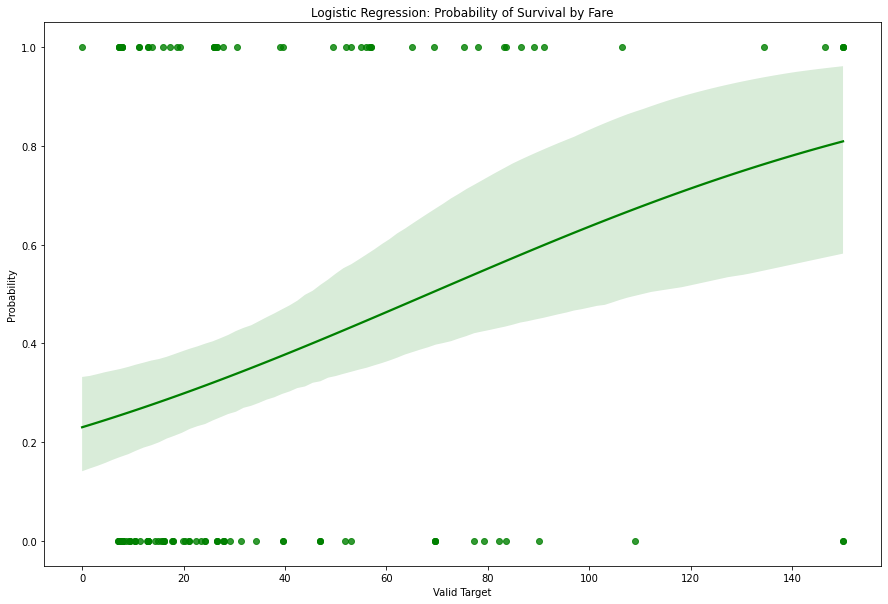

In [ ]:
def ap_log_regplot(ap_X, ap_y):
    plt.figure(figsize=(15,10))
    sns.regplot(ap_X, ap_y, logistic=True, color='green')
    return None

ap_log_regplot(x_valid['Fare'], y_valid)
plt.xlabel('Valid Target')
plt.ylabel('Probability')
plt.title('Logistic Regression: Probability of Survival by Fare')
plt.show()

- logit linearity 확인

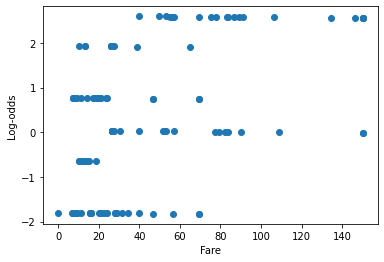

In [ ]:
import numpy as np
# Getting log odds values
log_odds = np.log(predict_prob / (1 - predict_prob))

# Visualize predictor variable vs logit values for Age
plt.scatter(x=x_valid['Fare'].values, y=log_odds)
plt.xlabel("Fare")
plt.ylabel("Log-odds")
plt.show()

- 해당 실습에서는 비선형 패턴을 보여주므로 로짓 선형성 가정이 위반됨 (polynomial terms 등 고차 다항식 항을 통합하여 변환을 수행할 수 있음. [참고](https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290))

- cut-off 설정

In [ ]:
# 경계값cut off value에 따라 0,1 값 변환
def change_cutoff(pred_prob_y, cutoff):
    Y_change = pred_prob_y.copy()
    Y_change[Y_change > cutoff] = 1
    Y_change[Y_change <= cutoff] = 0
    return(Y_change.astype(int))

In [ ]:
print(confusion_matrix(y_valid, change_cutoff(predict_prob, 0.5)))
print(" Accuracy:", accuracy_score(y_valid, change_cutoff(predict_prob, 0.5)))
print("Precision:", precision_score(y_valid, change_cutoff(predict_prob, 0.5)))
print("   Recall:", recall_score(y_valid, change_cutoff(predict_prob, 0.5)))
print(" F1 score:", f1_score(y_valid, change_cutoff(predict_prob, 0.5)))

[[60 31]
 [10 42]]
 Accuracy: 0.7132867132867133
Precision: 0.5753424657534246
   Recall: 0.8076923076923077
 F1 score: 0.672


In [ ]:
print(confusion_matrix(y_valid, change_cutoff(predict_prob, 0.7)))
print(" Accuracy:", accuracy_score(y_valid, change_cutoff(predict_prob, 0.7)))
print("Precision:", precision_score(y_valid, change_cutoff(predict_prob, 0.7)))
print("   Recall:", recall_score(y_valid, change_cutoff(predict_prob, 0.7)))
print(" F1 score:", f1_score(y_valid, change_cutoff(predict_prob, 0.7)))

[[90  1]
 [22 30]]
 Accuracy: 0.8391608391608392
Precision: 0.967741935483871
   Recall: 0.5769230769230769
 F1 score: 0.7228915662650601


- ROC curve: 다양한 threshold에 대한 이진분류기의 성능을 한번에 표시한 그래프
  - TPR: true positive rate
  - FPR: false positive rate
  - 좌측 상단으로 붙어있는 경우 좋은 분류기
- [참고](https://angeloyeo.github.io/2020/08/05/ROC.html)

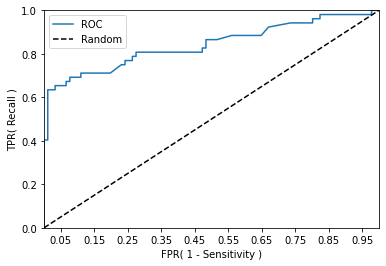

In [ ]:
from sklearn.metrics import roc_curve

def roc_curve_plot(y_test , pred_proba_c1):
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1) # 임곗값에 따른 FPR, TPR 값을 반환 받음. 

    plt.plot(fprs , tprs, label='ROC')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
  
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
  
roc_curve_plot(y_valid, predict_prob)

# Step 5. Interpretation
- [Deviance](http://contents2.kocw.or.kr/KOCW/document/2017/chungbuk/najonghwa/5.pdf)
  - saturated model: 연구모형이 해당 데이터에 대해 완전히 적합된 모형으로, 추정해야할 모수가 전체 변수의 수와 동일
  - null model: 절편항만 가지고 X 변수 어떤것도 모델에 반영되지 않는 경우(Y=b_0)로, 추정할 모수가 1개
  - fitted model: p개의 모수+절편항을 포함하는 모형이므로 추정할 모수가 p+1개
  - **residual deviance**: 2{LL(saturated model) - LL(fitted model)}, df=n-(p+1)
  - **null deviance**: 2{LL(saturated model) - LL(null model)}, df=n-1
  - 두 deviance는 값이 작을수록 해당 모형이 자료를 잘 적합함을 의미
  - 영모형과 제안모형 간의 비교(검정)는 (Null Deviance - Proposed Deviance)가 근사적으로 자유도가 (n-(p+1))-(n-1)=p인 카이제곱분포를 따른다는 사실에 기초
  - 이는 [`glm()`](https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLM.html)에서 활용 가능

In [ ]:
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  416
Model:                          Logit   Df Residuals:                      411
Method:                           MLE   Df Model:                            4
Date:                Fri, 15 Apr 2022   Pseudo R-squ.:                  0.3007
Time:                        12:47:21   Log-Likelihood:                -201.64
converged:                       True   LL-Null:                       -288.35
Covariance Type:            nonrobust   LLR p-value:                 1.937e-36
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6136      0.518      5.047      0.000       1.599       3.629
Pclass_2      -0.6780      0.445     -1.522      0.128      -1.551       0.195
Pclass_3      -1.8453      0.442     -4.179      0.000      -2.711      -0.980
Sex_male      -2.5684      0.262     -9.806      0.000      -3.082      -2.055
Fare          -0.0004      0.006     -0.074      0.941      -0.011       0.010
==============================================================================
"""

In [ ]:
model_sm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.325     
Dependent Variable: Survived         AIC:              496.8037  
Date:               2022-04-15 12:38 BIC:              518.0728  
No. Observations:   520              Log-Likelihood:   -243.40   
Df Model:           4                LL-Null:          -360.44   
Df Residuals:       515              LLR p-value:      1.7558e-49
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
const         2.3366    0.4599    5.0812  0.0000   1.4353   3.2379
Pclass_2     -0.5752    0.3830   -1.5019  0.1331  -1.3257   0.1754
Pclass_3     -1.6881    0.3847   -4.3876  0.0000  -2.4422  -0.9340
Sex_male     -2.5854    0.2420  -10.6820  0.0000  -3.0598  -2.1110
Fare          0.0073    0.0057    1.2761  0.2019  -0.0039   0.0185
=================================================================

"""

- reference: (Pclass = 1, Sex = Female)
- Logit(Survived = 1) = 2.3366 - 0.5752 \* Pclass_2 - 1.6881 \*Pclass_3 - 2.5854 \* Sex_Male + 0.0073 \* Fare
- p-value가 유의수준 0.05 이하인 변수: Pclass_3, Sex_male

- 이 외 기타 항목들에 대한 해석 [참고1](https://investigate.ai/regression/evaluating-logistic-regressions/), [참고2](https://stackoverflow.com/questions/46700258/python-how-to-interpret-the-result-of-logistic-regression-by-sm-logit)

In [ ]:
# Odds ratio
import numpy as np
np.exp(model_sm.params) # reference: (Pclass = 1, Sex = Female)

const       10.346151
Pclass_2     0.562613
Pclass_3     0.184869
Sex_male     0.075365
Fare         1.007319
dtype: float64

- Pclass_3을 이용하는 승객은 Pclass_1을 이용하는 승객보다 odds가 0.184배 증가한다. (즉, odds가 약 81.6% 감소)
- 성별이 male인 승객은 femalie인 승객보다 odds가 0.075배 증가한다. (즉, odds가 약 92.5% 감소)

# Appendices

## Sklearn

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1e9)
model.fit(x_train, y_train)

LogisticRegression(C=1000000000.0)

In [ ]:
print(model.intercept_) 
print(model.coef_)

## reference: (Pclass=1, Sex=Female)

[1.30682024]
[[ 1.30682024e+00 -6.77969790e-01 -1.84533864e+00 -2.56844346e+00
  -4.11293881e-04]]


In [ ]:
print(model.predict_proba(x_train)[:5]) # 0=사망, 1=생존 : 각 관측치별..[0(사망)일 확률, 1(생존)일 확률]

[[0.63844786 0.36155214]
 [0.84291015 0.15708985]
 [0.84330705 0.15669295]
 [0.52363976 0.47636024]
 [0.84291015 0.15708985]]


## K-fold CV
- hold-out: train/validation/test set을 split

- cross validation: 데이터셋을 k개의 subset으로 구분 후 k-1개의 subset을 train을 위해, 나머지 하나의 subset을 test를 위해 사용
  - 일반적으로 K=10을 사용하나, 데이터셋이 클 경우 계산 속도를 고려하여 k의 값을 줄이기도 함
  - 데이터셋이 많지 않을 경우 여러 번 샘플링하여 검증하는 과정을 거칠 수 있음
- cross validation을 사용할 경우 imbalanced data에 민감할 수 있음
  - class가 유사한 경우 `from sklearn.model_selection import KFold`을 통해 일반적인 kfold 사용
  - imbalanced인 경우 `from sklearn.model_selection import StratifiedKFold`을 통해 class의 수를 고려하여 kfold cv를 진행

- 여기서부터는 `sklearn`의 `LogitRegression` 활용

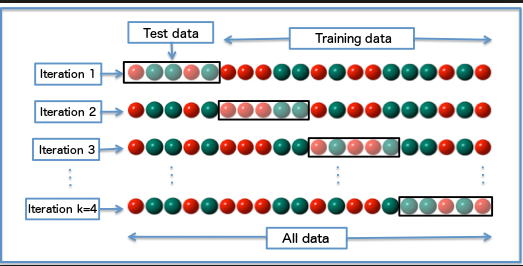

In [ ]:
from sklearn.model_selection import cross_validate
# from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np

# kfold = KFold(n_splits=10, shuffle=True, random_state=312) # K-Fold 객체 생성
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=312) # stratified K-Fold 객체 생성

# sklearn 관련 (cross-validation, measure) 추가 학습 링크:
# https://scikit-learn.org/stable/modules/cross_validation.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score

In [ ]:
'''
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
penalty: 'l1', 'l2', 'elasticnet', 'none' (default: l2)
fit_intercept: True, False (default: True)
'''
from sklearn.linear_model import LogisticRegression
model_cv = LogisticRegression()

In [ ]:
# Stratified k-fold CV
# Accuracy 기준: cross_val_score(model, featrues, target, cross validation)
scores = cross_validate(model_cv, train_features, train_target, cv=kfold, # (model, featrues, target, cross validation)
                        scoring=['accuracy', 'recall', 'precision', 'f1', 'roc_auc']) 
                        # precision/recall macro/micro : https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
{k: np.mean(v) for k, v in scores.items()}

{'fit_time': 0.013747453689575195,
 'score_time': 0.006105589866638184,
 'test_accuracy': 0.7845443196004994,
 'test_f1': 0.7089483170254843,
 'test_precision': 0.7414851849012832,
 'test_recall': 0.684453781512605,
 'test_roc_auc': 0.8393844891491951}

In [ ]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(model_cv, train_features, train_target, cv=kfold)

## Types of Logistic Regression 
- target variable에 따라 3가지로 구분할 수 있음
1. **Binary Logistic Regression**
  - target variable: 두 개의 categories
  - e.g., yes or no, good or bad, true or false, spam or no spam and pass or fail.

2. Multinomial Logistic Regression
  - target variable: 세 개 이상의 nominal (순서가 없는) categories
  - e.g., apple, mango, orange and banana.

3. Ordinal Logistic Regression
  - target variable: 세 개 이상의 ordinal categories
  - e.g., poor, average, good and excellent.